We can also show the sketch a second time taking into account the new values:

C:\Users\SUSHANT\AppData\Local\Temp\ipykernel_21556\2556572726.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette='muted')


Image shape: (3648, 5472, 3)
Dominant colors (top 3 RGB): [[185, 190, 139], [27, 32, 22], [212, 205, 194]]
Detections:
 - ball bbox (1648, 156, 5, 20) score 0.9417072630886686
 - ball bbox (2464, 165, 9, 16) score 0.99
 - ball bbox (4058, 205, 39, 24) score 0.8250943017036597
 - ball bbox (4023, 240, 20, 28) score 0.8754713436951136
 - ball bbox (2608, 299, 16, 13) score 0.99
 - ball bbox (2656, 304, 16, 12) score 0.99
 - ball bbox (2560, 310, 17, 15) score 0.9546000455166603
 - ball bbox (0, 336, 23, 48) score 0.917218858059646
 - ball bbox (4440, 492, 55, 23) score 0.8185418254146088
 - ball bbox (4496, 509, 6, 13) score 0.99
 - ball bbox (3799, 518, 17, 12) score 0.99
 - ball bbox (1820, 642, 17, 11) score 0.99
 - ball bbox (3488, 670, 16, 9) score 0.99
 - ball bbox (1856, 745, 16, 7) score 0.9577403187921353
 - ball bbox (1680, 784, 15, 11) score 0.99
 - ball bbox (1699, 810, 14, 21) score 0.99
 - ball bbox (2932, 831, 11, 8) score 0.99
 - ball bbox (1218, 846, 24, 7) score 0.81881

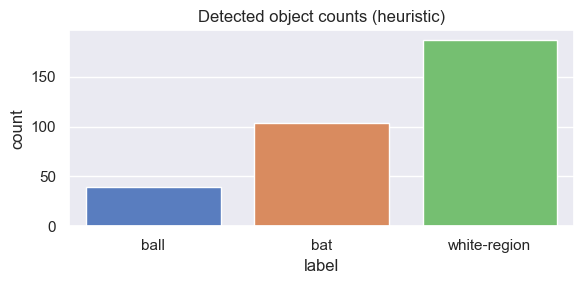

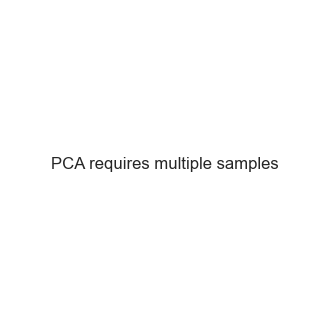

In [2]:
import os
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.color import rgb2gray, rgb2hsv
from skimage.feature import hog, canny
from skimage.morphology import closing, disk
from skimage.measure import label, regionprops
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

sns.set()
IMAGE_PATH = "sample.jpg"
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# --- Load image ---
if not os.path.exists(IMAGE_PATH):
    raise FileNotFoundError(f"Image not found: {IMAGE_PATH}. Put the image file in the same folder.")

pil_img = Image.open(IMAGE_PATH).convert("RGB")
img = np.array(pil_img)  # shape (H,W,3), dtype=uint8
h, w, _ = img.shape

# --- Color histograms (RGB) ---
bins = 256
hist_r, _ = np.histogram(img[:,:,0].ravel(), bins=bins, range=(0,255))
hist_g, _ = np.histogram(img[:,:,1].ravel(), bins=bins, range=(0,255))
hist_b, _ = np.histogram(img[:,:,2].ravel(), bins=bins, range=(0,255))

# --- Dominant colors (KMeans) ---
pixels = img.reshape(-1, 3).astype(np.float32)
k = 5
km = KMeans(n_clusters=k, random_state=0, n_init=10)
labels = km.fit_predict(pixels)
centers = km.cluster_centers_.astype(int)
counts = np.bincount(labels)
dominant = centers[np.argsort(-counts)]

# --- HOG descriptor (global) ---
gray = rgb2gray(img)  # floats in [0,1]
hog_vec, hog_image = hog(gray, pixels_per_cell=(16,16), cells_per_block=(2,2),
                         visualize=True, feature_vector=True)

# --- Red mask detection using HSV (skimage uses H in [0,1]) ---
hsv = rgb2hsv(img)  # shape (H,W,3), floats in [0,1]
h_ch = hsv[:,:,0]  # hue
s_ch = hsv[:,:,1]
v_ch = hsv[:,:,2]

# red wraps near 0 and 1 -> combine two ranges
mask_red1 = (h_ch >= 0.0) & (h_ch <= 0.05) & (s_ch > 0.4) & (v_ch > 0.2)
mask_red2 = (h_ch >= 0.95) & (h_ch <= 1.0) & (s_ch > 0.4) & (v_ch > 0.2)
mask_red = mask_red1 | mask_red2
# morphological closing to join fragments
mask_red = closing(mask_red, disk(5))

# label connected components
lbl_red = label(mask_red)
props_red = regionprops(lbl_red)

detections = []

# detect red circular blobs (ball candidates)
for p in props_red:
    area = p.area
    if area < 50:
        continue
    # equivalent diameter -> estimate radius
    eq_diam = p.equivalent_diameter
    radius = eq_diam / 2.0
    # circularity estimate: 4*pi*area / perimeter^2 (if perimeter>0)
    perim = p.perimeter if p.perimeter > 0 else 1.0
    circularity = (4.0 * np.pi * area) / (perim * perim)
    # bounding box
    minr, minc, maxr, maxc = p.bbox
    bw = maxc - minc
    bh = maxr - minr
    # heuristics: relatively circular and small radius
    if circularity > 0.4 and radius > 3 and radius < max(h,w)*0.15:
        detections.append({
            "label": "ball",
            "bbox": (minc, minr, bw, bh),
            "score": float(min(0.99, 0.4 + circularity))
        })

# --- Edge + contour analysis (Canny) to detect long thin objects (bat) ---
edges = canny(gray, sigma=2.0)
edges_closed = closing(edges, disk(2))
lbl_edges = label(edges_closed)
props_edges = regionprops(lbl_edges)

for p in props_edges:
    minr, minc, maxr, maxc = p.bbox
    bw = maxc - minc
    bh = maxr - minr
    area = p.area
    if bw * bh < 200:
        continue
    aspect = bw / float(bh + 1e-9)
    # bat candidates: elongated or large aspect ratio
    if aspect > 3.0 or (aspect > 1.8 and bw > w * 0.25):
        detections.append({
            "label": "bat",
            "bbox": (minc, minr, bw, bh),
            "score": 0.85
        })

# --- White regions -> person clothing / pads / helmet (bright white) ---
# rgb2gray returns [0..1]; threshold accordingly
white_mask = rgb2gray(img) > 0.86  # approx > 220/255
white_mask = closing(white_mask, disk(5))
lbl_white = label(white_mask)
props_white = regionprops(lbl_white)

for p in props_white:
    minr, minc, maxr, maxc = p.bbox
    bw = maxc - minc
    bh = maxr - minr
    if bw * bh < 500:
        continue
    detections.append({
        "label": "white-region",
        "bbox": (minc, minr, bw, bh),
        "score": 0.7
    })

# --- Draw detections on image using PIL ---
draw_img = pil_img.copy()
draw = ImageDraw.Draw(draw_img)
try:
    font = ImageFont = None
except Exception:
    font = None

for d in detections:
    x, y, bw, bh = d["bbox"]
    # draw rectangle
    draw.rectangle([x, y, x+bw, y+bh], outline=(255,0,0), width=3)
    txt = f"{d['label']}:{d['score']:.2f}"
    # draw text background for readability
    text_pos = (x, max(y-12, 0))
    draw.rectangle([text_pos, (text_pos[0]+len(txt)*7+6, text_pos[1]+12)], fill=(255,0,0))
    draw.text((text_pos[0]+3, text_pos[1]), txt, fill=(255,255,255))

draw_img.save(os.path.join(OUT_DIR, "detections.png"))

# --- Bar chart of detections ---
labels = [d['label'] for d in detections] if detections else []
if labels:
    unique, counts = np.unique(labels, return_counts=True)
else:
    unique, counts = np.array([]), np.array([])

plt.figure(figsize=(6,3))
if labels:
    sns.barplot(x=unique, y=counts, palette='muted')
else:
    plt.text(0.5, 0.5, "No detections", horizontalalignment='center', verticalalignment='center')
plt.title("Detected object counts (heuristic)")
plt.ylabel("count")
plt.xlabel("label")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "object_counts.png"))

# --- Feature vector for PCA: downsampled color histograms + HOG (sampled) ---
# use 32-bin hist per channel to reduce size
hist_bins = 32
hr, _ = np.histogram(img[:,:,0].ravel(), bins=hist_bins, range=(0,255))
hg, _ = np.histogram(img[:,:,1].ravel(), bins=hist_bins, range=(0,255))
hb, _ = np.histogram(img[:,:,2].ravel(), bins=hist_bins, range=(0,255))
color_hist_small = np.concatenate([hr, hg, hb]).astype(float)
hog_small = hog_vec[:1024] if hog_vec.size >= 1024 else np.pad(hog_vec, (0, 1024 - hog_vec.size))
feat = np.concatenate([color_hist_small.ravel(), hog_small.ravel()]).reshape(1, -1)

# PCA (single point -> will be trivial; still save projection)
pca = PCA(n_components=2)
try:
    proj = pca.fit_transform(feat)
    plt.figure(figsize=(4,4))
    plt.scatter(proj[:,0], proj[:,1], c='blue')
    plt.title("Feature projection (PCA) — single image")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "feature_pca.png"))
except Exception:
    # if PCA fails (e.g., only one sample), save a placeholder
    fig, ax = plt.subplots(figsize=(4,4))
    ax.text(0.5, 0.5, "PCA requires multiple samples", ha='center', va='center')
    ax.set_axis_off()
    fig.savefig(os.path.join(OUT_DIR, "feature_pca.png"))

# --- Console summary ---
print("Image shape:", img.shape)
print("Dominant colors (top 3 RGB):", dominant[:3].tolist())
print("Detections:")
for d in detections:
    print(" -", d["label"], "bbox", d["bbox"], "score", d["score"])

print("Saved outputs to", OUT_DIR)